# Hidden Markov Chain and Stock Market Regimes

           0            1            2
Up: 0.45000 0.32400 0.23328
Down: 0.20000 0.05600 0.02592
Most likely states: ['Up', 'Up', 'Up'] probability= 0.23328000000000004


Model is not converging.  Current: 13105.26042152218 is not greater than 13105.288605631327. Delta is -0.028184109147332492
C:\Users\13464\AppData\Local\Temp\ipykernel_2348\2415850873.py:95: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax.plot_date(px.index[1:][mask], px.iloc[1:][mask], ".", linestyle='none', c=colour, markersize=4)


Model score (log likelihood): 13105.190545321844
Percentage of hidden state 1 = 5.241%

Transition matrix
[[8.11351102e-01 1.88648173e-01 7.24971374e-07]
 [9.31344901e-01 2.52444427e-02 4.34106564e-02]
 [7.20656850e-03 3.25827031e-02 9.60210728e-01]]

Means and variances of each hidden state
0th state mean : [0.0011581]
0th state var  : [4.0683782e-05]
1th state mean : [-0.0019276]
1th state var  : [0.00018358]
2th state mean : [-0.00168866]
2th state var  : [0.00069308]


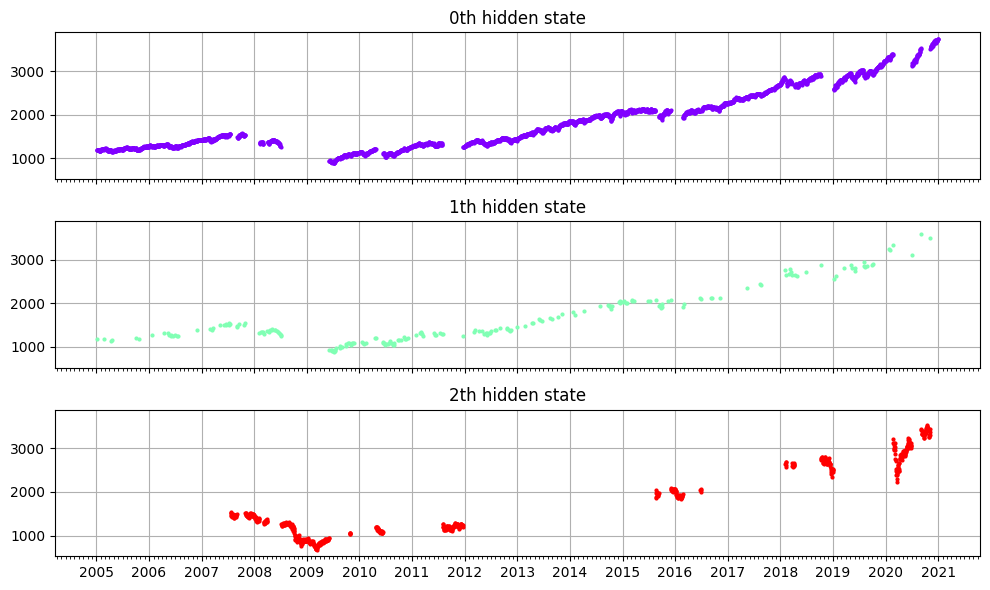

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from datetime import datetime, date
from hmmlearn.hmm import GaussianHMM


obs      = ('happy', 'happy', 'happy')
states   = ('Up', 'Down')
start_p  = {'Up': 0.5, 'Down': 0.5}
trans_p  = {'Up': {'Up': 0.8, 'Down': 0.2},
            'Down': {'Up': 0.3, 'Down': 0.7}}
emit_p   = {'Up': {'happy': 0.9, 'unhappy': 0.1},
            'Down': {'happy': 0.4, 'unhappy': 0.6}}

def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    for st in states:
        V[0][st] = {"prob": start_p[st] * emit_p[st][obs[0]], "prev": None}
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = max(V[t-1][prev]["prob"] * trans_p[prev][st] for prev in states)
            for prev in states:
                if V[t-1][prev]["prob"] * trans_p[prev][st] == max_tr_prob:
                    V[t][st] = {"prob": max_tr_prob * emit_p[st][obs[t]], "prev": prev}
                    break
    def dptable(V):                      # pretty‐print
        yield " ".join(("%12d" % i) for i in range(len(V)))
        for s in V[0]:
            yield "%.7s: " % s + " ".join("%.7s" % ("%f" % v[s]["prob"]) for v in V)
    for line in dptable(V):
        print(line)
    
    opt, max_prob = [], max(v["prob"] for v in V[-1].values())
    previous = max(V[-1], key=lambda st: V[-1][st]["prob"])
    opt.append(previous)
    for t in range(len(V)-2, -1, -1):
        previous = V[t+1][previous]["prev"]
        opt.insert(0, previous)
    print("Most likely states:", opt, "probability=", max_prob)

viterbi(obs, states, start_p, trans_p, emit_p)



ticker   = "^GSPC"               
start_dt = "2005-01-01"
end_dt   = "2020-12-31"


px = (
    yf.download(
        ticker,
        start=start_dt,
        end=end_dt,
        auto_adjust=False,       
        progress=False
    )
    .loc[:, "Close"]
    .squeeze()                  # DataFrame → Series
)

rets = np.log(px).diff().dropna().values.reshape(-1, 1)


hmm_model = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=1000,
    random_state=42
).fit(rets)

print("Model score (log likelihood):", hmm_model.score(rets))

hidden_states = hmm_model.predict(rets)
print(f"Percentage of hidden state 1 = {np.mean(hidden_states==1):.3%}")

print("\nTransition matrix")
print(hmm_model.transmat_)

print("\nMeans and variances of each hidden state")
for i in range(hmm_model.n_components):
    print(f"{i}th state mean :", hmm_model.means_[i])
    print(f"{i}th state var  :", np.diag(hmm_model.covars_[i]))


fig, axs = plt.subplots(hmm_model.n_components, sharex=True, sharey=True, figsize=(10,6))
colours = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = hidden_states == i
    ax.plot_date(px.index[1:][mask], px.iloc[1:][mask], ".", linestyle='none', c=colour, markersize=4)
    ax.set_title(f"{i}th hidden state")
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.grid(True)

plt.tight_layout()
plt.show()
